# COMP1801 Tutorial Week 6 - Numerical Optimisation
*Dr Peter Soar - 2023/24*

This sixth tutorial is taking a bit of a change of pace to take a look at one of the more theoretical things happening under the hood of our machine learning algorithms - undertanding how numerical optimisation can be used to minimise the error in our models.

While you will not generally be programming these methods directly (`sklearn` and `tensorflow` can usually take care of that in practice - though there may be cases where you want to implement new methods manually before they are supported by libraries such as these), it's important that you understand the concepts of optimisation and how to choose an appropriate learning rate (another hyperparameter!).

In particular, when you get back after welcome week we will be looking at Neural Networks, where an appreciation of the importance of the learning rate and the general principles of gradient based optimisation will be important for understanding and implementing NNs.

For this tutorial, read through and try to understand the text and code examples I have provided (ask your tutor if you have any questions) and then attempt the selection of exercises I have provided. Attempt these exercises on your own, but do ask your tutor for help if you get stuck.

##0. Do not forget to import all the Python Libraries being used!

In [1]:
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices
import pandas as pd # A common package for viewing tabular data
import tensorflow as tf # Tensor flow is a key package for performing automatic differntiation (the gradient descent we use for optimisation)
import sklearn.linear_model, sklearn.datasets # We want to be able to access the sklearn datasets again, also we are using some model evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler # We will be using the imbuilt sclaing functions sklearn provides
from sklearn.model_selection import train_test_split #for splitting our data
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs

Reminder: To execute a cell, press SHIFT + ENTER or hit the 'play' button on the left of the cell

# 1. Automatic differentiation

As explained in the lectures, our cost function is, as it's a name suggests, simply a mathematical function which relates the parameters of our model (the values in our $\theta$ vector describing our hypothesis) to the error of the models which we want to find the minial value for using optimisation.

In order to formulate our optimisation problem I will start with some revision about defining a function and obtaining the function derivative, then showing how tensorflow can help us with this.

## 1.1 Functions and differentiation

A function, at $J$ maps the elements in the set $\theta$ to the set $y$ at it's most basic definition such that $J(\theta) = y = a * \theta^n$ (note, the more usual form you will see in mathematics is $f(x) = y = a * x^n$, but I am using our cost function notation for consistency). The derivative of this function at a given point is the slope of the tangent of the function at that point, which lets us know how that function is changing at that point.

The differentiation function follows a lot of rules depending on the function you are trying to find the derivative of, so I will just give a few examples that will be helpful in this tutorial.


### 1.1.1 Differentiation of a standard function with powers
For a function of the form $J(\theta) = y = a * \theta^n$, the derivative of that function can be defined as
$\frac{d}{d\theta} J(\theta)= n \times a \theta^{n-1}$

Example:

Let $a=5$, $n=3$ and $\theta=-2$.

Define $J$ by $J(\theta) = a \theta^n = 5 \theta^{3}$.

Then: $J(-2) = 5 (-2)^3=-40$

Find the derivative:

$\frac{d}{d\theta} J(\theta)= n \times a \times \theta^{n-1} = 3 \times 5 \times \theta^2=15\theta^2$

Value at $\theta=-2$: $\frac{d}{d\theta} J(-2)= 15\times -2^2 = 60$

### 1.1.2 Differentiation of a standard function with exponentials
For a function of the form $J(\theta) = y = \exp (\theta^n + a)$ (where $\exp (x)$ is Napier's constant defined by $\mathrm{e}^x$, where $\mathrm{e}=2.71828...$ ), the derivative of that function can be defined as
$\frac{d}{d\theta} J(\theta)= n\theta^{n-1} \times \exp (\theta^n + a)$

Example:

Let $a=3$, $n=2$ and $\theta=1$.

Define $J$ by $J(\theta) = \exp (\theta^n + a) = \exp (\theta^2 + 3)$.

Then: $J(1) = \exp (1^2 + 3)=54.59815$

Find the derivative:

$\frac{d}{d\theta} J(\theta)= n\theta^{n-1} \times \exp (\theta^n + a) = 2\theta \times \exp (\theta^2 + 3)$

Value at $\theta=1$: $\frac{d}{d\theta} J(1)= 2\times 1  \times \exp (1^2 + 3) = 2 \exp (4) = 109.1963$


Functions and differention are fundamental topics in mathematics, so I won't go into any further detail here, but you should be able to find extensive examples of differentiation if you search for 'A level calculus' and 'differentiation rules' either in books or online.

##1.2 Defining a function to differentiate in Python (Tensorflow)

Define the "variable" (to which which we will calculate the derivative.)
- `tf.Variable(value, dtype=np.float32)`
  - `value` can be a python list, numpy array, or tensorflow Tensor, and will be regarded as the initial value.

Define the "constants" (any variable for which we do not need to calculate the derivative)
- `tf.constant(value, dtype=np.float32)`
  - `value` is the value of the "constant Tensor"
  - Strictly speaking, the "Tensor" defined by this is computationally immutable, so not "constant."

Note: Tensorflow gives us access to many mathematical functions we may have used prior with Numpy.
- Operators are similar to those in Numpy
  - `+, -, *, /`: elementwise addition $+$, subtraction $-$, multiplication $\otimes$, division $\oslash$.
  - `@`: matrix product
- Most mathmatical function can be given by replacing np of a Numpy function by tf.math.
  - `np.sin(x), np.cos(x), np.exp(x)` $\to$ `tf.math.sin(x), tf.math.cos(x), tf.math.exp(x)`.

##1.3 How to differentiate a function automatically?
The following is the general process we follow for automatically differentiating functions in Python:

- Define the Variables (e.g., `th` for  $\theta$) and any constants
- Define return value (e.g., `j` for $J(\theta)$ at some value for $\theta$) of the function we want to differentiate in `tf.gradientTape() as tape:` block
- Get the gradient by `tape.gradient()` (e.g., `tape.gradient(j, th)`)
  - The 0th parameter: the return value instance (e.g., `j`).
  - The 1st parameter: the variable instance (e.g., `th`).
- The `GradientTape()` can seem a bit confusing at first. All it is doing is 'recording' all tensorflow operations that have been performed, which allows you to go back and 'look' at the tape to find the gradient at a specific point.


In [2]:
th = tf.Variable(-2, dtype=np.float32) # Defining a variable `th`. Here, the initial value is -2. In the following, the derivative will be calculated for `th`.
a = tf.constant(5, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 5.

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block.
  j = a * (th ** 3)
  return j

with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
  j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

# What is the value of our function at `th=-2`?
print('J(-2) =', j.numpy()) # To convert an TensorFlow instance to a NumPy instance, we use the `numpy()` method.

# What is the derivative of our function at `th=-2`?
# tape.gradient(j, th) takes the return value `j` and the variable value `th` to give the derivative at that point.
dj_dth = tape.gradient(j, th) # To calculate the derivative of the function, we use `tape.gradient` method.
print('d/dth J(-2) =', dj_dth.numpy())



J(-2) = -40.0
d/dth J(-2) = 60.0


### 1.3.1 Automatically differentiate of a standard function with powers
Using the same function as in *1.1.1* - for a function of the form $J(\theta) = y = a * \theta^n$, the derivative of that function can be defined as
$\frac{d}{d\theta} J(\theta)= n \times a \theta^{n-1}$.
Let $a=5$, $n=3$ and $\theta=-2$, find the derivative $\frac{d}{d\theta} J(\theta)$:


We should be able to see this matches our example above.

### 1.3.2 Automatically differentiate of a standard function with exponentials
Using the same function as in *1.1.2* - for a function of the form $J(\theta) = y = \exp (\theta^n + a)$, the derivative of that function can be defined as
$\frac{d}{d\theta} J(\theta)= n\theta^{n-1} \times \exp (\theta^n + a)$.
Let $a=3$, $n=2$ and $\theta=1$, find the derivative $\frac{d}{d\theta} J(\theta)$:

In [3]:
th = tf.Variable(1, dtype=np.float32) # Defining a variable `th`. Here, the initial value is 1. In the following, the derivative will be calculated for `th`.
a = tf.constant(3, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 3.

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block.
  j = tf.math.exp(th ** 2 + a) # We use tf.math.exp to implement the exponential function.
  return j

with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
  j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

# What is the value of our function at `th=1`?
print('J(1) =', j.numpy()) # To convert an TensorFlow instance to a NumPy instance, we use the `numpy()` method.

# What is the derivative of our function at `th=1`?
# tape.gradient(j, th) takes the return value `j` and the variable value `th` to give the derivative at that point.
dj_dth = tape.gradient(j, th) # To calculate the derivative of the function, we use `tape.gradient` method.
print('d/dth J(1) =', dj_dth.numpy())

J(1) = 54.59815
d/dth J(1) = 109.1963


Again, we should have a match to what we did by hand above.

### 1.3.3 Task 1: Differentiate the sigmoid function
Consider the sigmoid function which takes the form:
$$J(\theta) = \frac{1}{1 + \exp (- a \theta)}$$


Let $a=1$ and $\theta=0$, find the derivative $\frac{d}{d\theta} J(\theta)$:


In [4]:
##############################################################
# Your code here
##############################################################




th = tf.Variable(0.0, dtype=np.float32)
a = tf.constant(1.0, dtype=np.float32)
def j_func(th):
  j = 1.0 / (1.0 + tf.math.exp(- a * th))
  return j

with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
  j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

# What is the value of our function at `th=0`?
print('J(0) =', j.numpy()) # To convert an TensorFlow instance to a NumPy instance, we use the `numpy()` method.

# What is the derivative of our function at `th=0`?
# tape.gradient(j, th) takes the return value `j` and the variable value `th` to give the derivative at that point.
dj_dth = tape.gradient(j, th) # To calculate the derivative of the function, we use `tape.gradient` method.
print('d/dth J(0) =', dj_dth.numpy())

J(0) = 0.5
d/dth J(0) = 0.25


If your code working correctly your code should give you the results: $J(0)=0.5$ and $\frac{d}{d\theta} J(0)=0.25$.

Though if you want to do some maths to double check this and differenetiate the sigmoid function by hand be my guest!

##1.4 Gradient descent

The objective of the gradient descent method is to find the vector $\boldsymbol{\theta}$ which minimises our function $J(\boldsymbol{\theta})$. It does this by calcuating the derivative at a point on the function then updating the position to closer to the minimum based on the gradient at that point and the user defined `learning_rate`.

A reminder that the `learning_rate` is a hyperparameter - as it change the behaviour of your model while it learns as it tries to find the optimal $\boldsymbol{\theta}$.

Algorithm
- Inputs:
  - The initial parameter guess $\boldsymbol{\theta}_\textrm{init}$ (note: ideally we would want to choose values close to the minimum - but if we knew what that was that we wouldn't be needing to use this method! Consequently, you generally start by intiialisng the vector just with something generic like zeros or ones)
  - The Learning rate $\alpha$. This must take a value of $\alpha >0$ and is generally less than $1$, but you have to experiment to find the best value for this hyperparameter.
- Initialization: Set your parameter vector $\boldsymbol{\theta} = \boldsymbol{\theta}_\textrm{init}$.
- Repeat the following steps until convergence (when $\boldsymbol{\theta}$ stops changing):
  - Calculate the value of the derviative of the function at the current  $\boldsymbol{\theta}$ values and save this as the variable $\boldsymbol{g} =\frac{\partial}{\partial \boldsymbol{\theta}} J (\boldsymbol{\theta})$
  - Update your estimate of $\boldsymbol{\theta}$ using $\boldsymbol{g}$ and $\alpha$ using: $\boldsymbol{\theta} = \boldsymbol{\theta} - \alpha \boldsymbol{g}$

###1.4.1 How to apply the gradient descent algorithm in TensorFlow
**Note**: The following explains low-level interfaces of TensorFlow. For machine learning problems, you can also use high-level interfaces of TensorFlow, which will be explained in following weeks.
- Create `tf.optimizers.SGD` instance.
  - inputs: learning rate $\alpha$.
- For each step in the loop, get the gradient using `tape.gradient` and update the parameters using `optimizers.apply_gradients` from our SGD instance.
  - inputs: the sequence of pairs (tuples of length 2) of the `tf.Variable` instance and the gradient given by `tape.gradient` method for that iteration

Hopefully the commented example below will make things clearer if you don't quite understand.

###1.4.1 Gradient Descent algorithm Example
For our problem we want to find the $\theta$ that minimizes the function $J (\theta)$.

Let:
- $J (\theta) = - \exp(- (\theta - a)^2)$, where $a = 0.5$
- An initial guess $\theta_\textrm{init} = 0.0$
- A learning rate $\alpha = 0.1$

(The solution to this problem should be $J (\theta)$ takes the minimum value $-1.0$ at $\theta = 0.5$)


In [6]:
# Define the objective function
th = tf.Variable(0, dtype=np.float32) # Defining a variable `th`, this is our `initial guess`
a = tf.constant(0.5, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 5.

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block.
  j = - tf.math.exp(- (th - a) ** 2)
  return j

learning_rate = 0.1 # Our `alpha` which dictates how much our values can change in a single step.
optimizer = tf.optimizers.SGD(learning_rate) # creating our optimiser object
n_steps = 30 # Number of steps we want the SGD to run
display_interval = 1 # How often we want to print our outputs (for this case printing every iteration is fine, but you would not want to do this if you were running thousands of iterations)

for i_step in range(n_steps): # Start loop running from 1-n_steps
  with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
    j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

  dj_dth = tape.gradient(j, th) # Getting the gradient at current theta

  #Note: zip() function combines [dj_dth], [th] into a zipped tuple form the optimiser function needs
  optimizer.apply_gradients(zip([dj_dth], [th])) # Updating `th` using the gradient `dj_dth`.

  # print the current status
  if i_step % display_interval == 0:
    print(f'step {i_step:0=2}: j = {j.numpy():+2.4f}, th = {th.numpy():+2.4f}, dj/dth = {dj_dth.numpy():+2.4f}')

# print the final results
j = j_func(th)
print(f'Final results: j = {j.numpy():+2.4f}, th = {th.numpy():+2.4f}')
# Note print(f'....') allows us to format any variables being called

step 00: j = -0.7788, th = +0.0779, dj/dth = -0.7788
step 01: j = -0.8368, th = +0.1485, dj/dth = -0.7064
step 02: j = -0.8838, th = +0.2107, dj/dth = -0.6213
step 03: j = -0.9197, th = +0.2639, dj/dth = -0.5322
step 04: j = -0.9458, th = +0.3085, dj/dth = -0.4466
step 05: j = -0.9640, th = +0.3455, dj/dth = -0.3691
step 06: j = -0.9764, th = +0.3756, dj/dth = -0.3018
step 07: j = -0.9847, th = +0.4001, dj/dth = -0.2449
step 08: j = -0.9901, th = +0.4199, dj/dth = -0.1978
step 09: j = -0.9936, th = +0.4358, dj/dth = -0.1592
step 10: j = -0.9959, th = +0.4486, dj/dth = -0.1278
step 11: j = -0.9974, th = +0.4589, dj/dth = -0.1025
step 12: j = -0.9983, th = +0.4671, dj/dth = -0.0822
step 13: j = -0.9989, th = +0.4736, dj/dth = -0.0658
step 14: j = -0.9993, th = +0.4789, dj/dth = -0.0527
step 15: j = -0.9996, th = +0.4831, dj/dth = -0.0422
step 16: j = -0.9997, th = +0.4865, dj/dth = -0.0337
step 17: j = -0.9998, th = +0.4892, dj/dth = -0.0270
step 18: j = -0.9999, th = +0.4914, dj/dth = -

###1.4.2 Task 2
Now try applying the SGD yourself to find the $\theta$ that minimizes the function $J (\theta)$.

Let:
- $J (\theta) = \frac{a^2}{\theta} + \theta$, where $a = 0.5$
- An initial guess $\theta_\textrm{init} = 1.0$
- A learning rate $\alpha = 0.1$

(The solution to this problem should be $J (\theta)$ takes the minimum value $1.0$ at $\theta = 0.5$)

To understand the algorithm better, also try altering the following and see how it effects the algorithm:
*   Change the initial guess $\theta_\textrm{init}$ to be closer and further away from the true answer (you might find something interesting if you move too far away...)
*   Try other values of $\alpha$ (remember it must be greater than 0)
*   Try changing the number of steps




In [7]:
##############################################################
# Your code here
##############################################################

# Define the objective function
th = tf.Variable(0, dtype=np.float32) # Defining a variable `th`, this is our `initial guess`
a = tf.constant(0.5, dtype=np.float32) # Defining a constant `a`. Here, the value is set to 5.

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block.
  j = - tf.math.exp(- (th - a) ** 2)
  return j

learning_rate = 0.1 # Our `alpha` which dictates how much our values can change in a single step.
optimizer = tf.optimizers.SGD(learning_rate) # creating our optimiser object
n_steps = 30 # Number of steps we want the SGD to run
display_interval = 1 # How often we want to print our outputs (for this case printing every iteration is fine, but you would not want to do this if you were running thousands of iterations)

for i_step in range(n_steps): # Start loop running from 1-n_steps
  with tf.GradientTape() as tape: # The gradienttape function allows us to track the tensorflow computations which it uses to calculate the gradients with respect to our `th`
    j = j_func(th) # Using `j_func` function defined above, we define the return value of the function.

  dj_dth = tape.gradient(j, th) # Getting the gradient at current theta

  #Note: zip() function combines [dj_dth], [th] into a zipped tuple form the optimiser function needs
  optimizer.apply_gradients(zip([dj_dth], [th])) # Updating `th` using the gradient `dj_dth`.

  # print the current status
  if i_step % display_interval == 0:
    print(f'step {i_step:0=2}: j = {j.numpy():+2.4f}, th = {th.numpy():+2.4f}, dj/dth = {dj_dth.numpy():+2.4f}')

# print the final results
j = j_func(th)
print(f'Final results: j = {j.numpy():+2.4f}, th = {th.numpy():+2.4f}')
# Note print(f'....') allows us to format any variables being called

step 00: j = -0.7788, th = +0.0779, dj/dth = -0.7788
step 01: j = -0.8368, th = +0.1485, dj/dth = -0.7064
step 02: j = -0.8838, th = +0.2107, dj/dth = -0.6213
step 03: j = -0.9197, th = +0.2639, dj/dth = -0.5322
step 04: j = -0.9458, th = +0.3085, dj/dth = -0.4466
step 05: j = -0.9640, th = +0.3455, dj/dth = -0.3691
step 06: j = -0.9764, th = +0.3756, dj/dth = -0.3018
step 07: j = -0.9847, th = +0.4001, dj/dth = -0.2449
step 08: j = -0.9901, th = +0.4199, dj/dth = -0.1978
step 09: j = -0.9936, th = +0.4358, dj/dth = -0.1592
step 10: j = -0.9959, th = +0.4486, dj/dth = -0.1278
step 11: j = -0.9974, th = +0.4589, dj/dth = -0.1025
step 12: j = -0.9983, th = +0.4671, dj/dth = -0.0822
step 13: j = -0.9989, th = +0.4736, dj/dth = -0.0658
step 14: j = -0.9993, th = +0.4789, dj/dth = -0.0527
step 15: j = -0.9996, th = +0.4831, dj/dth = -0.0422
step 16: j = -0.9997, th = +0.4865, dj/dth = -0.0337
step 17: j = -0.9998, th = +0.4892, dj/dth = -0.0270
step 18: j = -0.9999, th = +0.4914, dj/dth = -

##1.5 Using SGD for functions with multiple parameters using vectors/matrices
So far we have only been looking at how to optimise functions with a single parameter, however in reality we are mostly going to be using multivariable functions.
We can account for this by defining vectors and matrices as `tf.Variable` and `tf.constant` instances where we input a list or a NumPy array when creating the variables.


##1.5.1 Two Parameter Example

For a function $J(\boldsymbol{\theta}) = \sum_{i=0,1}(\theta_{i} - c_{i})^2 =\theta_{0}^2 -2c_{0}\theta_{0} + c_{0}^2 +\theta_{1}^2 -2c_{1}\theta_{1} + c_{1}^2 = (\boldsymbol{\theta} - \boldsymbol{c})^\top (\boldsymbol{\theta} - \boldsymbol{c})$, let our constant vector $\boldsymbol{c} = \begin{bmatrix}c_0 \\ c_1\end{bmatrix}= \begin{bmatrix}2 \\ 3\end{bmatrix}$ and our parameter vector be $\boldsymbol{\theta}  = \begin{bmatrix}\theta_0 \\ \theta_1\end{bmatrix} = \begin{bmatrix}5 \\ 4\end{bmatrix}$


Find:


*   $ J \left(\begin{bmatrix}5 \\ 4\end{bmatrix}\right)$
*   $\frac{\partial}{\partial \boldsymbol{\theta}} J \left(\begin{bmatrix}5 \\ 4\end{bmatrix}\right) $


Solution:
- $J \left(\begin{bmatrix}5 \\ 4\end{bmatrix}\right) =5^2 -2\times 2 \times 5 + 2^2 + 4^2 -2\times 3 \times 4 + 3^2= 10$
- $\frac{\partial}{\partial \boldsymbol{\theta}} J (\boldsymbol{\theta}) = 2 (\boldsymbol{\theta} - \boldsymbol{c})$ (note: this differentiation involves the chain rule, don't worry if you don't fully follow how this worked).
- $\frac{\partial}{\partial \boldsymbol{\theta}} J \left(\begin{bmatrix}5 \\ 4\end{bmatrix}\right) = 2 \left(\begin{bmatrix}5 \\ 4\end{bmatrix} - \begin{bmatrix}2 \\ 3\end{bmatrix}\right) = \begin{bmatrix}6 \\ 2\end{bmatrix}.$



In [8]:
# Then solve using Python
th_by_list = [[5],[4]] # Define our list of parameters
c_by_list = [[2],[3]] # Define our list of constants

# Make both into TensorFLow objects
th = tf.Variable(th_by_list, dtype=np.float32)
c = tf.constant(c_by_list, dtype=np.float32)


def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block.
  j = tf.transpose(th - c) @ (th - c) # (th - c).T does not work in Tensorflow, and remember that `@` is how TF does matrix multiplication.
  return j

with tf.GradientTape() as tape:
  j = j_func(th)


dj_dth = tape.gradient(j, th)
print('j =')
print(j.numpy())
print('dj/dth =')
print(dj_dth.numpy())

j =
[[10.]]
dj/dth =
[[6.]
 [2.]]


Now we have shown how to differentiate this function, we can also now use the SGD method to find the values of $\boldsymbol{\theta}$ that minimise $J(\boldsymbol{\theta})$.

In [9]:

th_by_list = [[5],[4]] # Define our list of parameters
c_by_list = [[2],[3]] # Define our list of constants

# Make both into TensorFLow objects
th = tf.Variable(th_by_list, dtype=np.float32)
c = tf.constant(c_by_list, dtype=np.float32)

def j_func(th): # It is convenient to define the function we want to differentiate before the `tf.GradientTape` block.
  j = tf.transpose(th - c) @ (th - c) # (th - c).T does not work in Tensorflow, and remember that `@` is how TF does matrix multiplication.
  return j

learning_rate = 0.1
optimizer = tf.optimizers.SGD(learning_rate)
n_steps = 80
display_interval = 10 # The output with vectors is quite long and ugly, so I have increased the display interval
for i_step in range(n_steps):
  with tf.GradientTape() as tape:
    j = j_func(th)

  dj_dth = tape.gradient(j, th) # get gradient

  optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

  # print the current status
  if i_step % display_interval == 0:
    print(f'step {i_step:0=2}: \nj = \n{j.numpy()}, \nth = \n{th.numpy()}, \ndj/dth = \n{dj_dth.numpy()} \n')

# print the final results
j = j_func(th)
print(f'Final results: j = {j.numpy()}, th = {th.numpy()}')


step 00: 
j = 
[[10.]], 
th = 
[[4.4]
 [3.8]], 
dj/dth = 
[[6.]
 [2.]] 

step 10: 
j = 
[[0.11529217]], 
th = 
[[2.257698 ]
 [3.0858994]], 
dj/dth = 
[[0.64424515]
 [0.21474838]] 

step 20: 
j = 
[[0.00132923]], 
th = 
[[2.0276701]
 [3.0092235]], 
dj/dth = 
[[0.06917524]
 [0.02305841]] 

step 30: 
j = 
[[1.5325564e-05]], 
th = 
[[2.0029712]
 [3.0009904]], 
dj/dth = 
[[0.00742769]
 [0.00247622]] 

step 40: 
j = 
[[1.7679969e-07]], 
th = 
[[2.000319 ]
 [3.0001063]], 
dj/dth = 
[[0.00079775]
 [0.00026608]] 

step 50: 
j = 
[[2.0259563e-09]], 
th = 
[[2.000034 ]
 [3.0000114]], 
dj/dth = 
[[8.535385e-05]
 [2.861023e-05]] 

step 60: 
j = 
[[2.2566837e-11]], 
th = 
[[2.0000036]
 [3.0000012]], 
dj/dth = 
[[9.059906e-06]
 [2.861023e-06]] 

step 70: 
j = 
[[4.5474735e-13]], 
th = 
[[2.0000005]
 [3.0000005]], 
dj/dth = 
[[9.536743e-07]
 [9.536743e-07]] 

Final results: j = [[4.5474735e-13]], th = [[2.0000005]
 [3.0000005]]


# 2. Optimisation in machine learning

So far we have been looking at optimisation in the somewhat abstract realm of mathematics, but what we really care about is how we can apply this to our ML models to find the best hypothesis.

These days, most famous machine learning models are generally already implemented in machine learning libraries such as `sklearn`, which makes out lives a lot easier as elements such as the optimisation have already been implemented. However, we sometimes may find a new model in a recent academic paper/blog that has not been implemented in those libraries - in that case, we will have to implement the cost function of the model and optimise it by ourselves.


In the following section we will practice implementing a machine learning model and its optimisation from scratch. I'm going to be looking at regression cases as the cost function is a bit nicer to deal with, but the same principle is used for optimising classification models.

## 2.1 Step 1 - Load the data

You should all hopefully be quite familliar with loading data from sklearn now, in particular the California housing dataset.

In [10]:
# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Xy_df = pd.concat([X_pd, y_pd], axis=1)

# show the data
display(Xy_df)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## 2.2 Step 2 - Split the data

Note, just for the sake of example I am only using train and test datasets (as I an not performing any model selection). But remember that in your coursework I am expecting you to use a more robust Train/Validate/Test model selection pipeline.

In [11]:
# Convert the data to `np.array`
X_raw = np.array(X_pd)
y = np.array(y_pd)

# Shuffle and split 20% of your data into a test set
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)

## 2.3 Step 3 - Data Pre-processing
As described in earlier lectures, feature scaling has multiple benefits for our ML implementation. A key one that we care about this week is better convergence behaviour for our GRadient Descent methods.

The two main methods we currently care about are Standardisation and Normalisation (MinMax Scaling), both of which are easy to apply using sklearn. For our case we will apply standardisation, which is generally a better choice for unbounded data like we are using.


### Revision - Standardization
By calculating the mean and variance for our data columns we can scale each feature so that it has a mean of 0 and a variance of 1.
$$x_s = \frac{x-\mu_x}{\sigma_x}$$
We can standardize the data by the `sklearn.preprocessing.StandardScaler` instance.
- Initialization: `StandardScaler` initializer.
- Calculating the mean and variance (standard deviation) by using `fit` with our object and data.
  - Input: the `np.array` instance of which to calculate the mean and variance.
- Apply the standardization using `transform`.



In [12]:
scaler = StandardScaler()
scaler.fit(X_train) # calculate the mean and variance for each feature and store to attributes
print(f'mean = \n{scaler.mean_}, \nvar = \n{scaler.var_}') # print the calculated mean and variance for each attribute
X_train_stded = scaler.transform(X_train) # standardize X_train
print(f'mean = \n{np.mean(X_train_stded, axis=0)}, \nvar = \n{np.var(X_train_stded, axis=0)}') # verify that X_train_stded has mean 0 (mean isn't quite 0 due to numerical error, but is a miniscule value) and variance 1.


mean = 
[ 3.87629834e+00  2.86190649e+01  5.43260683e+00  1.09617439e+00
  1.42543774e+03  3.03051803e+00  3.56247826e+01 -1.19563008e+02], 
var = 
[3.63560282e+00 1.58775552e+02 6.36723547e+00 2.39624237e-01
 1.30651333e+06 4.14883422e+01 4.56457763e+00 4.02078927e+00]
mean = 
[-2.17567405e-14 -1.14303485e-16  4.55873227e-15  1.07695476e-14
  5.41596806e-18 -2.24798899e-15  2.06778500e-14 -1.74326975e-13], 
var = 
[1. 1. 1. 1. 1. 1. 1. 1.]


### Append a column with 1s.
As some of you may remember from earlier weeks, when implementing Linear Regression from scratch, we need to have a column of '1s' to account for our intercept ($\theta_0$) when doing regression without applying a sklearn function. We can create a python function to do this as follows:

In [13]:
# Create 1 appending function
def append_one_to(X_without_one):
  X_with_one = np.pad(X_without_one, ((0, 0), (1, 0)), constant_values=1)
  return X_with_one

# Use this function to update our training data
X_train_stded_with_one = append_one_to(X_train_stded)

##2.4 Step 4: Optimising the Cost function - Mean Squared Error


### 2.4.1 Define the mean squared error using TensorFlow
As a quick reminder, the Cost function we are using currently is the Mean Squared Error (MSE), we are defining this as follows:
$$J(\boldsymbol{\theta}) = \frac{1}{m} \sum_{i=0}^{m-1} (\boldsymbol{X}_{i} \boldsymbol{\theta} - \boldsymbol{y}_{i})^2 = \frac{1}{m}(\boldsymbol{X} \boldsymbol{\theta} - \boldsymbol{y})^\top (\boldsymbol{X} \boldsymbol{\theta} - \boldsymbol{y})$$


where $X$ is our matrix of training feature data; $\boldsymbol{y}$ are the observed predicted target values for the target data; $\boldsymbol{\theta}$ is the parameter vector (hypothesis); $m$ is the number of rows in our training data and a subscript of $i$ indicates we are using the $i$th row of training data.

### 2.4.2 Task 3 - Implement the the mean squared error

For this task I just want you to alter one line to define the MSE correctly using tensorflow to match the definition above.

In [16]:
X = tf.constant(X_train_stded_with_one, dtype=np.float32) # Note, we can put a matrix in as a vector
y = tf.constant(y_train[:, np.newaxis], dtype=np.float32) # We use y as a column vector, that is, m x 1 2D array, not an 1D array. For this reason, we input y_train[:, np.newaxis]
m, n = X_train_stded_with_one.shape # We use the shape function to obtiam our number of rows - `m`
th = tf.Variable(tf.zeros([n, 1], dtype=np.float32)) # Create a vector of zeroes for our initial guess

def j_func(th):
  ####### Your code Here ###################
  j = 0 # Alter this j to calculate the MSE
  ####### end Code ###################
  j = tf.squeeze(j) # the `squeeze` function takes our 1x1 matrix and turns it into a scalar value.
  return j


### 2.4.3 Use the Steepest Gradient method to optimise your cost function

Now we have our data and cost function correctly applied, the application of Steepest gradient is the same as when solving other functions.

In [17]:
learning_rate = 0.1
optimizer = tf.optimizers.SGD(learning_rate)
n_steps = 100
display_interval = 1
for i_step in range(n_steps):
  with tf.GradientTape() as tape:
    j = j_func(th)

  dj_dth = tape.gradient(j, th)

  optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

  # Print the change of the objective function J
  # not printing out the derivative and th as that will be a lot of output, but feel free to add back if you are interest in their movements.
  if i_step % display_interval == 0:
    print(f'Step {i_step}: j = {j.numpy()}')

j = j_func(th)
print(f'j = {j.numpy()}\nth = \n{th.numpy()}')

ValueError: ignored

### 2.4.4 Make predictions for the target values using our parameters
Again, you should recognise this if you attempted the 'Linear Regression from scratch' task from last week. Essentially, multiplying our new data with the parameter vector will give us our predicted values for linear regression models - $h_{\boldsymbol{\theta}} (\boldsymbol{X_{new}}) = \boldsymbol{\hat{y}} =  \boldsymbol{X_{new}} \boldsymbol{\theta}$


Note: Make sure that any preprocessing done on `X_train` are also done to `X_new` (in this case standardisation and appending a column of 1's).

In [18]:
X_test_stded = scaler.transform(X_test) # Standardise new data
X_test_stded_with_one = append_one_to(X_test_stded) # Add a new

# Make your predictions
y_pred = tf.squeeze(X_test_stded_with_one @ th) # squeeze Makes matrix into a vector

y_pred.numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

Now let's try visualising our results and getting our evaluations metrics to see how well we have fit the data.

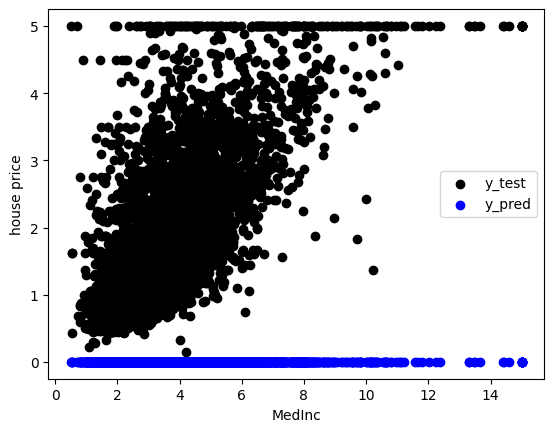

Mean squared error loss: 5.5179
R2 score: -3.2317


In [19]:
# Plot outputs
X_test_disp = X_test[:,0]
plt.scatter(X_test_disp, y_test,  color='black', label='y_test')
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred')
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

### 2.4.5 Task 4

Try implementing the Steepest Descent method to fit a model for the diabetes dataset - you can access it using `sklearn.datasets.load_diabetes()`. Try experimenting with the learning rate and number of steps to see where the accuracy gains plateau.

Extra: You'll find you don't get very good accuracy for the model even using all features. You could try implementing polynomial features and maybe even manual regularisation to see if they help! (still the best I was able to get after doing this was $R^2 = 45\%$)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


Step 0: j = 28762.72265625
Step 50: j = 2848.946044921875
Step 100: j = 2846.390869140625
Step 150: j = 2844.430908203125
Step 200: j = 2842.83056640625
Step 250: j = 2841.50244140625
Step 300: j = 2840.397216796875
Step 350: j = 2839.47509765625
Step 400: j = 2838.705078125
Step 450: j = 2838.0634765625
Step 500: j = 2837.52978515625
Step 550: j = 2837.083740234375
Step 600: j = 2836.71142578125
Step 650: j = 2836.400390625
Step 700: j = 2836.140380859375
Step 750: j = 2835.92236328125
Step 800: j = 2835.74267578125
Step 850: j = 2835.591552734375
Step 900: j = 2835.466796875
Step 950: j = 2835.3623046875
Step 1000: j = 2835.274658203125
Step 1050: j = 2835.20263671875
Step 1100: j = 2835.141357421875
Step 1150: j = 2835.08935546875
Step 1200: j = 2835.04736328125
Step 1250: j = 2835.0126953125
Step 1300: j = 2834.982666015625
Step 1350: j = 2834.957275390625
Step 1400: j = 2834.937744140625
Step 1450: j = 2834.919189453125
Step 1500: j = 2834.906494140625
Step 1550: j = 2834.89501953

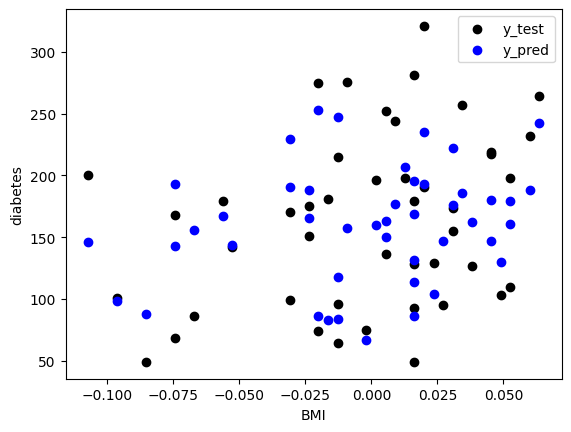

Mean squared error loss: 3111.9727
R2 score: 0.3572


In [20]:
##############################################################
# Your code here
##############################################################


# Load the house price dataset
X_pd, y_pd = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
Xy_df = pd.concat([X_pd, y_pd], axis=1)

# show the data
display(Xy_df)

# Convert the data to `np.array`
X_raw = np.array(X_pd)
y = np.array(y_pd)

# Shuffle and split 20% of your data into a test set
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.10, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train) # calculate the mean and variance for each feature and store to attributes
X_train_stded = scaler.transform(X_train) # standardize X_train

# Create 1 appending function
def append_one_to(X_without_one):
  X_with_one = np.pad(X_without_one, ((0, 0), (1, 0)), constant_values=1)
  return X_with_one

# Use this function to update our training data
X_train_stded_with_one = append_one_to(X_train_stded)

X = tf.constant(X_train_stded_with_one, dtype=np.float32) # Note, we can put a matrix in as a vector
y = tf.constant(y_train[:, np.newaxis], dtype=np.float32) # We use y as a column vector, that is, m x 1 2D array, not an 1D array. For this reason, we input y_train[:, np.newaxis]
m, n = X_train_stded_with_one.shape # We use the shape function to obtiam our number of rows - `m`
th = tf.Variable(tf.zeros([n, 1], dtype=np.float32)) # Create a vector of zeroes for our initial guess

def j_func(th):
  j = (1. / m ) * (tf.transpose(X @ th - y) @ (X @ th - y))
  j = tf.squeeze(j) # the `squeeze` function takes our 1x1 matrix and turns it into a scalar value.
  return j

learning_rate = 0.1
optimizer = tf.optimizers.SGD(learning_rate)
n_steps = 5000
display_interval = 50
for i_step in range(n_steps):
  with tf.GradientTape() as tape:
    j = j_func(th)

  dj_dth = tape.gradient(j, th)

  optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

  # Print the change of the objective function J
  # not printing out the derivative and th as that will be a lot of output, but feel free to add back if you are interest in their movements.
  if i_step % display_interval == 0:
    print(f'Step {i_step}: j = {j.numpy()}')

j = j_func(th)
print(f'j = {j.numpy()}\nth = \n{th.numpy()}')

X_test_stded = scaler.transform(X_test) # Standardise new data
X_test_stded_with_one = append_one_to(X_test_stded) # Add a new

# Make your predictions
y_pred = tf.squeeze(X_test_stded_with_one @ th) # squeeze Makes matrix into a vector

y_pred.numpy()

# Plot outputs
X_test_disp = X_test[:,0]
plt.scatter(X_test_disp, y_test,  color='black', label='y_test')
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred')
plt.xlabel('BMI')
plt.ylabel('diabetes')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


Step 0: j = 28894.830078125
Step 200: j = 2759.020751953125
Step 400: j = 2749.01904296875
Step 600: j = 2746.025146484375
Step 800: j = 2744.936767578125
Step 1000: j = 2744.503662109375
Step 1200: j = 2744.31982421875
Step 1400: j = 2744.240478515625
Step 1600: j = 2744.203125
Step 1800: j = 2744.185791015625
Step 2000: j = 2744.177001953125
Step 2200: j = 2744.17431640625
Step 2400: j = 2744.170654296875
Step 2600: j = 2744.1689453125
Step 2800: j = 2744.16943359375
j = 2744.169189453125
th = 
[[ 1.4976173e+02]
 [ 9.5409060e-01]
 [-6.2133961e+00]
 [ 2.1636282e+01]
 [ 1.7321009e+01]
 [-3.6900904e+00]
 [-4.1178041e+00]
 [-9.7723837e+00]
 [ 7.3107400e+00]
 [ 2.7362772e+01]
 [ 3.3775384e+00]
 [ 4.3049746e+00]
 [ 8.5762949e+00]
 [-7.2123989e-02]
 [ 6.5419710e-01]
 [-3.6129780e+00]
 [-4.9368782e+00]
 [ 8.5760393e+00]
 [ 7.7201476e+00]
 [ 2.9448955e+00]
 [ 2.2689548e+00]
 [-6.2133961e+00]
 [ 2.6060586e+00]
 [ 3.1930592e+00]
 [ 7.3598723e+00]
 [-7.0272574e+00]
 [ 1.4191203e+00]
 [-2.9391291

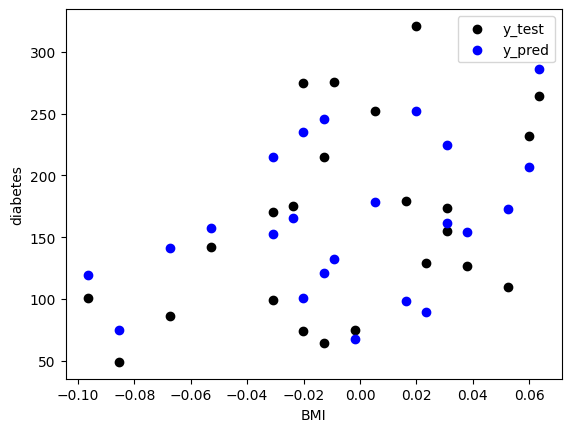

Mean squared error loss: 3225.4705
R2 score: 0.4486


In [21]:
##############################################################
# Your code here
##############################################################

from sklearn.preprocessing import PolynomialFeatures
# Load the diabetes dataset
X_pd, y_pd = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
Xy_df = pd.concat([X_pd, y_pd], axis=1)

# show the data
display(Xy_df)

# Convert the data to `np.array`
X_raw = np.array(X_pd)
y = np.array(y_pd)

# Shuffle and split 20% of your data into a test set
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.05, shuffle=True, random_state=0)

poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train) # Fit polynomial features on our raw training data
X_train_poly = poly.transform(X_train) # transform our raw data using the poly object
scaler = StandardScaler()
scaler.fit(X_train_poly) # calculate the mean and variance for each feature and store to attributes
X_train_stded = scaler.transform(X_train_poly) # standardize X_train

# Create 1 appending function
def append_one_to(X_without_one):
  X_with_one = np.pad(X_without_one, ((0, 0), (1, 0)), constant_values=1)
  return X_with_one

# Use this function to update our training data
X_train_stded_with_one = append_one_to(X_train_stded)

X = tf.constant(X_train_stded_with_one, dtype=np.float32) # Note, we can put a matrix in as a vector
y = tf.constant(y_train[:, np.newaxis], dtype=np.float32) # We use y as a column vector, that is, m x 1 2D array, not an 1D array. For this reason, we input y_train[:, np.newaxis]
m, n = X_train_stded_with_one.shape # We use the shape function to obtiam our number of rows - `m`
th = tf.Variable(tf.zeros([n, 1], dtype=np.float32)) # Create a vector of zeroes for our initial guess

reg=5.0

def j_func(th):
  j = (1. / m ) * (tf.transpose(X @ th - y) @ (X @ th - y)) + (reg / m ) * (tf.transpose(th) @ (th)) # ridge
  #j = (1. / m ) * (tf.transpose(X @ th - y) @ (X @ th - y)) + (reg) * ( tf.abs(tf.reduce_mean(th))) # Lasso
  j = tf.squeeze(j) # the `squeeze` function takes our 1x1 matrix and turns it into a scalar value.
  return j

learning_rate = 0.05
optimizer = tf.optimizers.SGD(learning_rate)
n_steps = 3000
display_interval = 200
for i_step in range(n_steps):
  with tf.GradientTape() as tape:
    j = j_func(th)

  dj_dth = tape.gradient(j, th)

  optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

  # Print the change of the objective function J
  # not printing out the derivative and th as that will be a lot of output, but feel free to add back if you are interest in their movements.
  if i_step % display_interval == 0:
    print(f'Step {i_step}: j = {j.numpy()}')

j = j_func(th)
print(f'j = {j.numpy()}\nth = \n{th.numpy()}')



X_test_poly = poly.transform(X_test)
X_test_stded = scaler.transform(X_test_poly) # Standardise new data
X_test_stded_with_one = append_one_to(X_test_stded)

# Make your predictions
y_pred = tf.squeeze(X_test_stded_with_one @ th) # squeeze Makes matrix into a vector

y_pred.numpy()

# Plot outputs
X_test_disp = X_test[:,0]
plt.scatter(X_test_disp, y_test,  color='black', label='y_test')
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred')
plt.xlabel('BMI')
plt.ylabel('diabetes')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

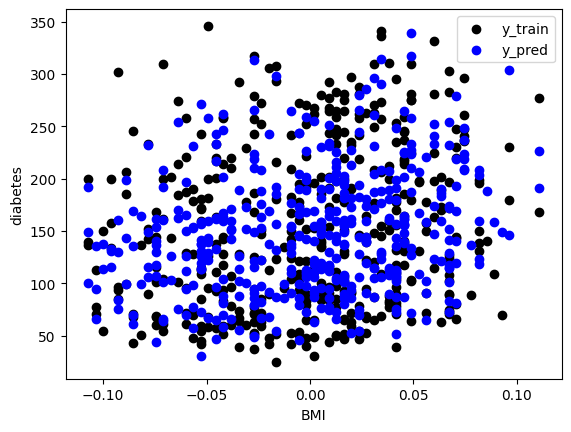

Mean squared error loss: 2429.4501
R2 score: 0.5902


In [22]:
# the training is quite a bit better, so seems we are overfitting!
# Make your predictions
y_pred = tf.squeeze(X_train_stded_with_one @ th) # squeeze Makes matrix into a vector

y_pred.numpy()

# Plot outputs
X_test_disp = X_train[:,0]
plt.scatter(X_test_disp, y_train,  color='black', label='y_train')
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred')
plt.xlabel('BMI')
plt.ylabel('diabetes')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_train, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_train, y_pred)))

### 2.4.6 Task 5 (challenging!)

$\newcommand{\Vec}[1]{\boldsymbol{#1}}$
$\newcommand{\Mat}[1]{\boldsymbol{#1}}$

For this final task I would like you to see if you are able to take what we have learned this week from the above regression examples to provide a manual Steepest Gradient Optimisation for a Classification problem (Logistic Regression).

Some insturctions/hints:
- Use the breast Cancer Dataset `load_breast_cancer` (though if you want to experiment with other classification problems you can).
- Implementation should be very similar to what we have done above with regression, but remember these key differences:
  - Logistic regression uses the Cross Entropy Loss Function (a few different ways you could calculate):
$$J(\Vec{\theta}) = -\frac{1}{m} \sum_{i=0}^{m-1} [(1-\Vec{y}) \ln (1 - \sigma (\Mat{X}\Vec{\theta})) + \Vec{y} \ln \sigma (\Mat{X}\Vec{\theta})] \\ $$
  - Where $\sigma(z)$ feeds our discriminant function into the sigmoid function to give us a probability:
$$\sigma(z) = \frac{1}{1 + \exp (- z)}$$
  - Our final predictions should be binary 1 or 0 values based on this probability output to give us our final hypothesis function:
  $$h_{\Vec{\theta}}(\Mat{X}) = \begin{cases}
0 & \textrm{if $\sigma(\Mat{X}\Vec{\theta}) < 0.5$,} \\
1 & \textrm{if $\sigma(\Mat{X}\Vec{\theta}) \ge 0.5$.}
\end{cases}$$
  - Hint: Remember we need to use `tensorflow` (**not** `numpy`) mathematic functions for tensorflow to find the gradient ([see this link](https://www.tensorflow.org/api_docs/python/tf/math))
  - Hint: If you want to visualise the decision boundary and/or use classification acuracy metrics look at last weeks tutorial for examples of how to implement.


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


Step 0: j = 0.6931472420692444
Step 1: j = 0.6755399703979492
Step 2: j = 0.659007728099823
Step 3: j = 0.6434801816940308
Step 4: j = 0.6288899779319763
Step 5: j = 0.6151727437973022
Step 6: j = 0.6022675633430481
Step 7: j = 0.5901172757148743
Step 8: j = 0.5786681175231934
Step 9: j = 0.5678701996803284
Step 10: j = 0.5576770901679993
Step 11: j = 0.5480456352233887
Step 12: j = 0.5389360785484314
Step 13: j = 0.5303117632865906
Step 14: j = 0.5221387147903442
Step 15: j = 0.5143857002258301
Step 16: j = 0.5070239305496216
Step 17: j = 0.5000269412994385
Step 18: j = 0.49337029457092285
Step 19: j = 0.48703160881996155
Step 20: j = 0.4809899628162384
Step 21: j = 0.475226491689682
Step 22: j = 0.4697234332561493
Step 23: j = 0.4644645154476166
Step 24: j = 0.4594348073005676
Step 25: j = 0.45462021231651306
Step 26: j = 0.45000800490379333
Step 27: j = 0.44558626413345337
Step 28: j = 0.44134393334388733
Step 29: j = 0.43727076053619385
Step 30: j = 0.4333571791648865
Step 31: j = 

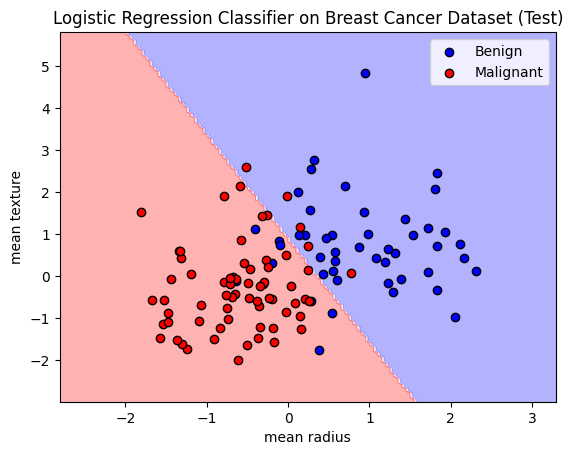

Accuracy: 88.60%


In [23]:
##############################################################
# Your code here
##############################################################


##############################################################
# Your code here
##############################################################
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
# Convert the data to `np.array`
# Note we are using the whole dataset - not a robust pipeline!

Xy_pd = pd.concat([X_pd, y_pd], axis=1)

display(Xy_pd)

# prepare NumPy ndarrays
X_raw = np.array(X_pd[['mean radius', 'mean texture']]) # just select two features
y = np.array(y_pd)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=1/5, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw) # calculate the mean and variance for each feature and store to attributes
X_train_stded = scaler.transform(X_train_raw) # standardize X_train

# Create 1 appending function
def append_one_to(X_without_one):
  X_with_one = np.pad(X_without_one, ((0, 0), (1, 0)), constant_values=1)
  return X_with_one

# Use this function to update our training data
X_train_stded_with_one = append_one_to(X_train_stded)

X = tf.constant(X_train_stded_with_one, dtype=np.float32) # Note, we can put a matrix in as a vector
y = tf.constant(y_train[:, np.newaxis], dtype=np.float32) # We use y as a column vector, that is, m x 1 2D array, not an 1D array. For this reason, we input y_train[:, np.newaxis]
m, n = X_train_stded_with_one.shape # We use the shape function to obtiam our number of rows - `m`
th = tf.Variable(tf.zeros([n, 1], dtype=np.float32)) # Create a vector of zeroes for our initial guess


def sigmoid(z):
    return 1 / (1 + tf.math.exp(-z))

def j_func(th):
  epsilon = 1e-15
  j = -tf.reduce_mean(y * tf.math.log(sigmoid(X@th) + epsilon) + (1 - y) * tf.math.log(1 - sigmoid(X@th) + epsilon))
  j = tf.squeeze(j) # the `squeeze` function takes our 1x1 matrix and turns it into a scalar value.
  return j

learning_rate = 0.1
optimizer = tf.optimizers.SGD(learning_rate)
n_steps = 100
display_interval = 1
for i_step in range(n_steps):
  with tf.GradientTape() as tape:
    j = j_func(th)

  dj_dth = tape.gradient(j, th)

  optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

  # Print the change of the objective function J
  # not printing out the derivative and th as that will be a lot of output, but feel free to add back if you are interest in their movements.
  if i_step % display_interval == 0:
    print(f'Step {i_step}: j = {j.numpy()}')

j = j_func(th)
print(f'j = {j.numpy()}\nth = \n{th.numpy()}')

X_test_stded = scaler.transform(X_test_raw) # Standardise new data
X_test_stded_with_one = append_one_to(X_test_stded) # Add a new

# Make your predictions
y_pred = tf.squeeze(X_test_stded_with_one @ th) # squeeze Makes matrix into a vector

y_pred.numpy()

# Create a meshgrid to plot the decision boundary
x_min, x_max = X_test_stded_with_one[:, 1].min() - 1, X_test_stded_with_one[:, 1].max() + 1
y_min, y_max = X_test_stded_with_one[:, 2].min() - 1, X_test_stded_with_one[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
# Predict the class labels for the points in the meshgrid
#Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(sigmoid(th[0]+th[1]*xx.ravel()+th[2]*yy.ravel()))
Z = np.array(tf.cast(Z >= 0.5, dtype=tf.float32))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.35, cmap = 'bwr')
X_neg = X_test_stded_with_one[y_test==0, :]
X_pos = X_test_stded_with_one[y_test==1, :]
plt.scatter(X_neg[:, 1], X_neg[:, 2], color='blue', edgecolors='black', label='Benign')
plt.scatter(X_pos[:, 1], X_pos[:, 2], color='red', edgecolors='black', label='Malignant')
plt.xlabel('mean radius')
plt.ylabel('mean texture')
plt.title(f'Logistic Regression Classifier on Breast Cancer Dataset (Test)')
plt.legend()
plt.show()

y_pred = y_pred>0
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")